# Support vector machine project
##### For the course 2022 Python Machine Learning & Data Science Masterclass

For this project, we will use the [Wine fraud dataset](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377) and create a SVM model capable of detecting low quality (or "fraud") wine samples. 

In [1]:
# Imports 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data exploration

We will first check the wine characteristics that will help us identify the quality.

In [2]:
wine_df = pd.read_csv('data/Wine_fraud.csv')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


In [3]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   object 
 12  type                  6497 non-null   object 
dtypes: float64(11), object(2)
memory usage: 660.0+ KB


We will check for the categorical columns first. 

We know that we have a "quality" column, let's see its possible values.

In [4]:
wine_df["quality"].value_counts()

Legit    6251
Fraud     246
Name: quality, dtype: int64

What about the "type" feature? Let's check the possible values and the relationship with the quality.

In [5]:
wine_df["type"].value_counts()

white    4898
red      1599
Name: type, dtype: int64

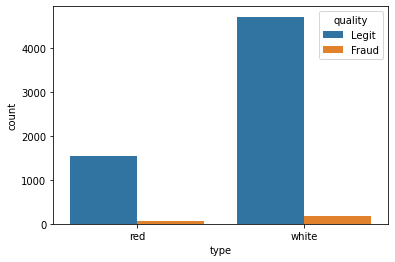

In [6]:
sns.countplot(data=wine_df, x='type', hue='quality')

In [7]:
red_wine = wine_df[wine_df["type"] == "red"]
white_wine = wine_df[wine_df["type"] == "white"]

In [8]:
print("Percentage of fraud in Red Wines:")
print(100* (len(red_wine[red_wine["quality"] == "Fraud"]) / len(red_wine)))

print("\n")

print("Percentage of fraud in White Wines:")
print(100* (len(white_wine[white_wine["quality"] == "Fraud"]) / len(white_wine)))

Percentage of fraud in Red Wines:
3.9399624765478425


Percentage of fraud in White Wines:
3.7362188648427925


We should change the "quality" column to an int column for the calculation of correlation between features. We can change the "Legit" value with a 0 and the "Fraud" value with a 1.

In [9]:
wine_df["Fraud"] = wine_df["quality"].map({"Legit": 0, "Fraud": 1})

Now we can calculate the correlation between the numerical features and the Fraud column.

In [10]:
wine_df.corr()['Fraud']

fixed acidity           0.021794
volatile acidity        0.151228
citric acid            -0.061789
residual sugar         -0.048756
chlorides               0.034499
free sulfur dioxide    -0.085204
total sulfur dioxide   -0.035252
density                 0.016351
pH                      0.020107
sulphates              -0.034046
alcohol                -0.051141
Fraud                   1.000000
Name: Fraud, dtype: float64

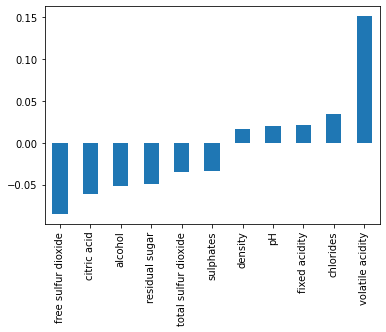

In [11]:
# We can plot how correlated to Fraud are the different features

# the :-1 is for except the fraud column
wine_df.corr()['Fraud'][:-1].sort_values().plot(kind='bar')

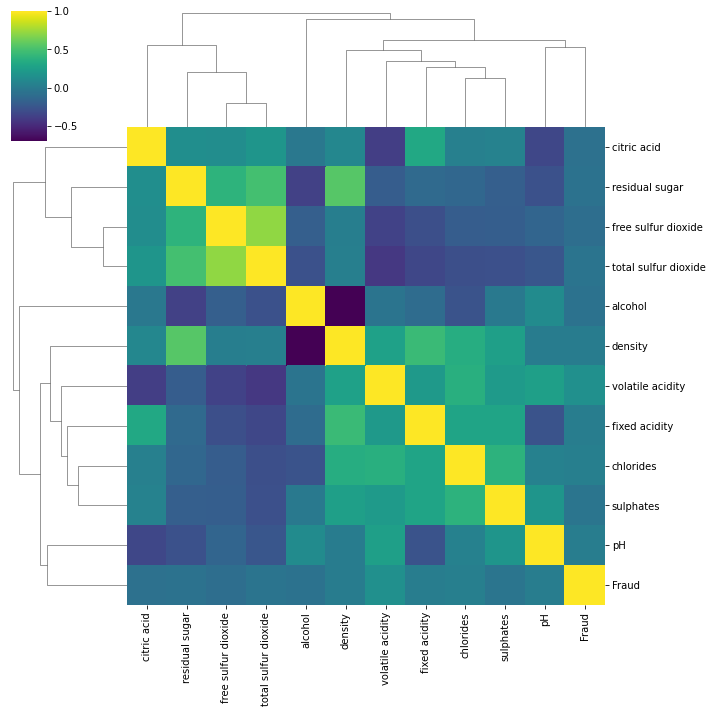

In [12]:
# Let's visualize the correlation between features in a clustermap
sns.clustermap(wine_df.corr(), cmap='viridis')

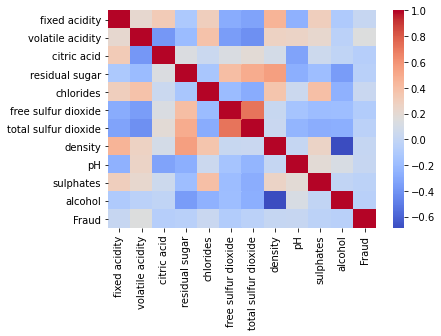

In [13]:
sns.heatmap(wine_df.corr(), cmap='coolwarm')

### Creation of train and test sets

Since we don't want duplicate columns, we need to remove the "Fraud" column. We already have "quality" as the predicion value.

In [14]:
wine_df = wine_df.drop("Fraud", axis=1)

We should also change the categorical "type" column to numerical using dummy variables. Since "type" has only two possible values, we can use the same column and have the values 0 and 1 instead of "red" and "white".

In [15]:
wine_df["type"] = pd.get_dummies(wine_df["type"], drop_first=True)

In [16]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,Legit,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,Legit,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,Legit,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,Legit,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,Legit,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,Legit,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,Legit,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,Legit,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,Legit,1


Let's prepare the features and the prediction, and then we can make the split for training and test sets.

In [17]:
X = wine_df.drop("quality", axis=1)
y = wine_df["quality"]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=52)

### Feature scaling

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Model creation

We will first create a support vector classifier and supply the value "balanced" to the "class_weight" parameter since we know our classes are unbalanced. This parameter defines the weight to apply to the C value in the calculation of the soft margin.

In [20]:
from sklearn.svm import SVC

smc_model = SVC(class_weight="balanced")

We will use GridSearchCV to find the best parameters to C and gamma.

In [21]:
from sklearn.model_selection import GridSearchCV

parameters_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1],
                   'gamma': ['scale', 'auto']}

grid_model = GridSearchCV(smc_model, parameters_grid)
grid_model.fit(scaled_X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
# Let's check the best parameters found
grid_model.best_params_

{'C': 1, 'gamma': 'auto'}

### Performance evaluation

In [23]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

grid_predictions = grid_model.predict(scaled_X_test)

In [24]:
confusion_matrix(y_test, grid_predictions)

array([[ 21,  14],
       [122, 818]])

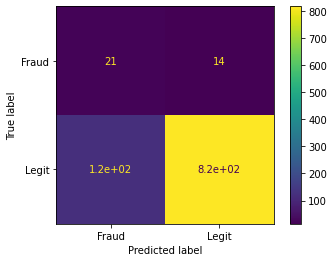

In [25]:
plot_confusion_matrix(grid_model, scaled_X_test, y_test)

In [26]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

       Fraud       0.15      0.60      0.24        35
       Legit       0.98      0.87      0.92       940

    accuracy                           0.86       975
   macro avg       0.57      0.74      0.58       975
weighted avg       0.95      0.86      0.90       975

